# File upload

In [3]:
#########     preparation block       #########
#   install mne package & upload eeg data files
###############################################
!pip install mne

from google.colab import files
uploaded = files.upload()

Saving EEG_Data_03.eeg to EEG_Data_03.eeg


# data initialization

In [ ]:
import os
import sys
import mne
import matplotlib.pyplot as plt
import time
plt.style.use('default')
import scipy.io as sio
import numpy as np
from scipy import signal
from scipy import fft
import array as arr
from pandas import DataFrame
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [44]:



START_ARG=0
STOP_ARG=240000
NumOfChannels = 70
vhdr_file = 'EEG_Data_03.vhdr'
raw_data = mne.io.read_raw_brainvision(vhdr_file, misc='auto', scale=1000000.0)
elec_names = raw_data.ch_names
data_info = (raw_data.get_data(start=START_ARG,stop = STOP_ARG))
dataFft = fft.fft(data_info,axis = 1)
#### define important electrodes ####
key_elecs = ['Fz','FCz','Cz','CPz','Pz']
for i in range(6):
    key_elecs.append('F' + str(i+1))
    key_elecs.append('C' + str(i+1))
    key_elecs.append('CP' + str(i+1))
    key_elecs.append('P' + str(i+1))
    key_elecs.append('FC' + str(i+1))

##### filter key elec channels #####
key_inds = []
for ind,ch_name in enumerate(elec_names):
    if ch_name in key_elecs:
        key_inds.append(ind)

key_data = data_info[key_inds]

#####   data filtering block  #####
zi_notch=[]
zi_band=[]
welch_1=18
welch_2=24
idx_topo=np.array(range(64))
freq_1_y=20
freq_2_y=20
order = 2
fs = 500
lowcut = 10
highcut = 40
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
      
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
        #Design notch filter
        
b_notch, a_notch = signal.iirnotch(f0, Q, fs)
b_band, a_band = signal.butter(order, [low, high], btype='band')

#zi_notch = signal.lfilter_zi(b_notch,a_notch)
#zi_band = signal.lfilter_zi(b_band,a_band)
for i in range(np.size(key_data,0)):
  zi_notch.append(signal.lfilter_zi(b_notch, a_notch))
  zi_band.append(signal.lfilter_zi(b_band, a_band))
def Filter_data(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data, zi_notch = signal.lfilter(b_notch, a_notch, data, axis=1, zi=zi_notch)
       data, zi_band = signal.lfilter(b_band, a_band, data, axis=1, zi=zi_band)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data, zi_notch,zi_band

def Filter_data_filtfilt(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data = signal.filtfilt(b_notch, a_notch, data, axis=1)
       data = signal.filtfilt(b_band, a_band, data, axis=1)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data









Extracting parameters from EEG_Data_03.vhdr...
Setting channel info structure...


# Pre & Post filter FFT check

Text(0.5, 0, 'f [Hz]')

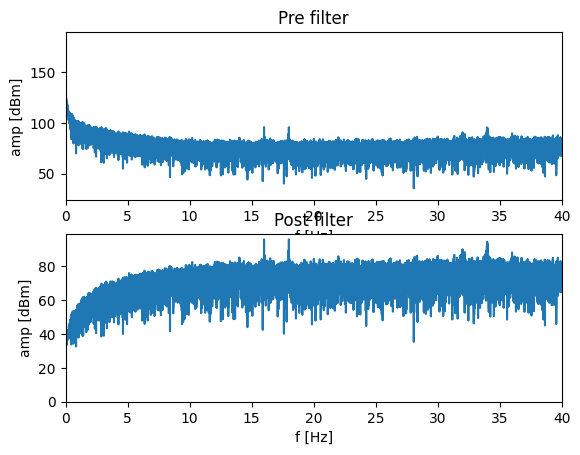

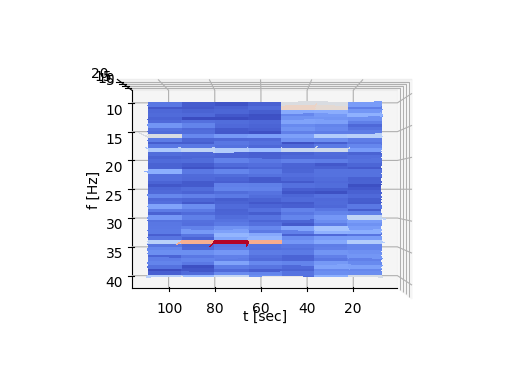

In [127]:
fig, (ax_o, ax_filt) = plt.subplots(2, 1,sharex=True)

plt.subplot(2, 1, 1)
f = fft.fftshift(fft.fft(key_data[1]))
xf = np.linspace(-fs/2, fs/2, np.size(f))
plt.plot(xf,2.0 * (10.0 * np.log10(np.abs(f)+30)))
plt.title('Pre filter')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
plt.xlim(left = 0, right = 40)
#plt.ylim(bottom = 0, top = 1)
#plt.plot((key_data[15]));

filtered_key_data, zi_notch , zi_band = Filter_data(key_data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band)
#plt.plot((filtered_key_data[15][100:]));
f_filt = fft.fftshift(x = fft.fft(filtered_key_data[1][:]))
plt.subplot(2, 1, 2)
plt.plot(xf,2.0 * (10.0 * np.log10(np.abs(f_filt)+30)))
plt.title('Post filter')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
plt.xlim(left = 0, right = 40)
plt.ylim(bottom = 0)
plt.show

########## Spectrogram try  ###########

fig = plt.figure()
ax = fig.gca(projection='3d')

f_1, t_1, spectro1  = signal.spectrogram(key_data[1][1000:60000],fs=fs,nperseg=8192)
f_1_crop=f_1[(f_1<=(highcut)) & (f_1>=(lowcut))]
spectro1_crop=2*(abs(spectro1[:][(f_1<=(highcut)) & (f_1>=(lowcut))]))
X, Y = np.meshgrid(t_1, f_1_crop)
surf = ax.plot_surface(X, Y,
                          spectro1_crop,
                          cmap=cm.coolwarm,
                          linewidth=0,
                          antialiased=False)
ax.view_init(90, 90)
ax.set_xlabel('t [sec]')
ax.set_ylabel('f [Hz]')


# Scipy Correlation check

Before filtering

<function matplotlib.pyplot.show>

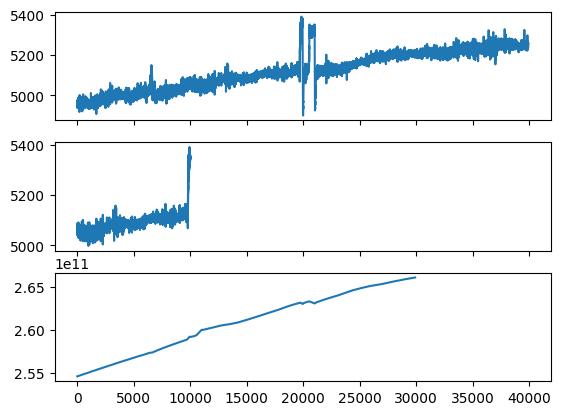

In [13]:
fig, (ax_sig, ax_kernel, ax_corr) = plt.subplots(3, 1, sharex=True)

### Correl
corr_cz = signal.correlate(key_data[1][100:40000],key_data[1][10000:20000],mode='valid')
np.size(corr_cz)
#time = np.arange(0,5000,1)

ax_sig.plot(key_data[1][100:40000])
ax_kernel.plot(key_data[1][10000:20000])
ax_corr.plot(corr_cz)
plt.show

After Filtering

<function matplotlib.pyplot.show>

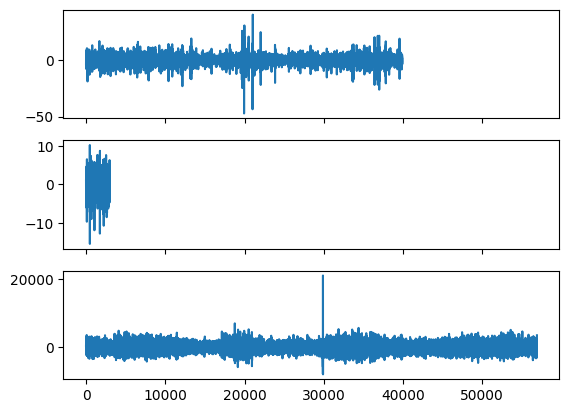

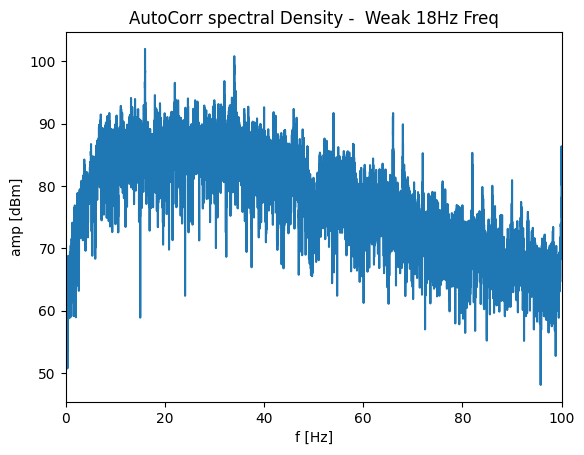

In [130]:
### Correl
kenrel_start_index = 30000
kenrel_stop_index = 33000
corr_cz = signal.correlate(filtered_key_data[1][100:60000],filtered_key_data[1][kenrel_start_index:kenrel_stop_index],mode='valid')
np.size(corr_cz)
corr_fft = fft.fftshift(fft.fft(corr_cz))
f_axis = np.linspace(-fs/2,fs/2,np.size(corr_fft))
#time = np.arange(0,5000,1)
fig, (ax_sig, ax_kernel, ax_corr) = plt.subplots(3, 1,sharex=True)
ax_sig.plot(filtered_key_data[1][100:40000])
ax_kernel.plot(filtered_key_data[1][kenrel_start_index:kenrel_stop_index])
ax_corr.plot(corr_cz)
fig = plt.figure()
plt.plot(f_axis,(10*np.log10(np.abs(corr_fft))+30))
plt.xlim(left=0,right=100)
plt.title('AutoCorr spectral Density -  Weak 18Hz Freq')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
##### Notice - the given example doenst have 18Hz Freq
plt.show

# Understanding the sum of sines behaviour

Simple behaviour observasion

array([0.30485924])

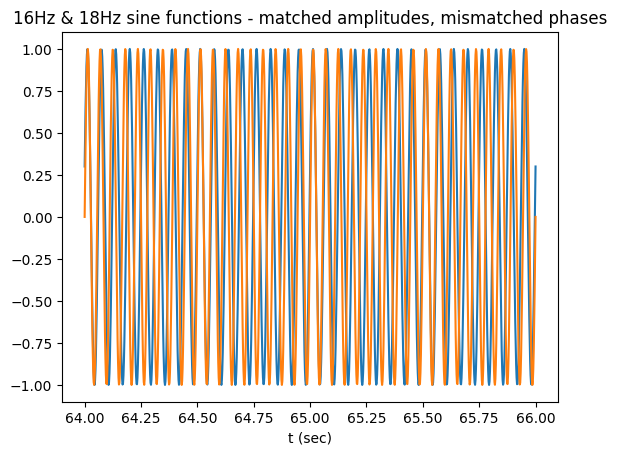

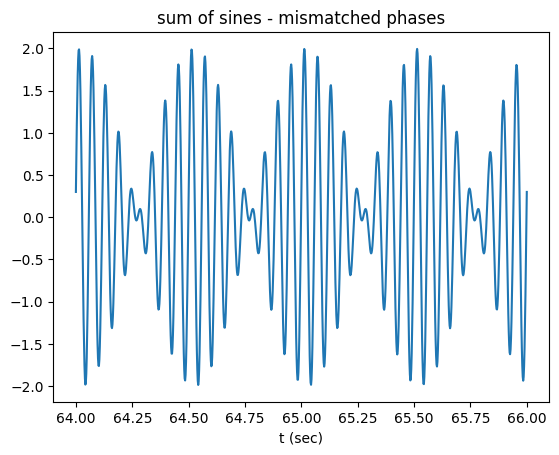

In [121]:
start_ind = 32000
end_ind = 33000
t = np.linspace(start_ind,end_ind,end_ind - start_ind) * 1/fs;
f_16 = 16
f_18 = 18
rand_ph = 2 * np.pi * np.random.rand(1)
sine_16 = np.sin(2 * np.pi * f_16 * t + rand_ph);
sine_18 = np.sin(2 * np.pi * f_18 * t);
plt.plot(t,sine_16);
plt.plot(t, sine_18)
plt.xlabel("t (sec)")

plt.title("16Hz & 18Hz sine functions - matched amplitudes, mismatched phases")
fig = plt.figure()

plt.plot(t, sine_16+sine_18)
plt.title("sum of sines - mismatched phases")
plt.xlabel("t (sec)")
rand_ph

display with eegData

Text(0.5, 1.0, 'EEg FCz electrode & sum of sines - mismatched phases & amplitudes')

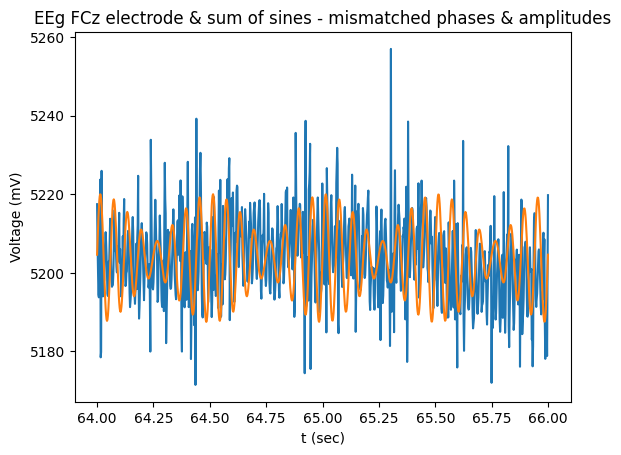

In [120]:
chosenElec = 1 # FCz

plt.plot(t,key_data[chosenElec][start_ind:end_ind])
# setting one of the amplitudes as the stddev of the EEG signal, the other is randomized from uniform distribution in range [amp1/2 amp1]
amp1 = np.std(key_data[chosenElec][start_ind:end_ind]) 
amp2 = np.random.uniform(low=amp1/2, high=amp1)


# the key_data average is set as the DC level for the sum of sines
sum_of_sines = np.average(key_data[chosenElec][start_ind:end_ind]) + amp1*(sine_16 + amp2/amp1*sine_18)


plt.plot(t,sum_of_sines)
plt.xlabel("t (sec)")
plt.ylabel("Voltage (mV)")
plt.title("EEg FCz electrode & sum of sines - mismatched phases & amplitudes")


Adding white noise

Text(0.5, 1.0, 'EEg FCz electrode & sum of sines with added white noise')

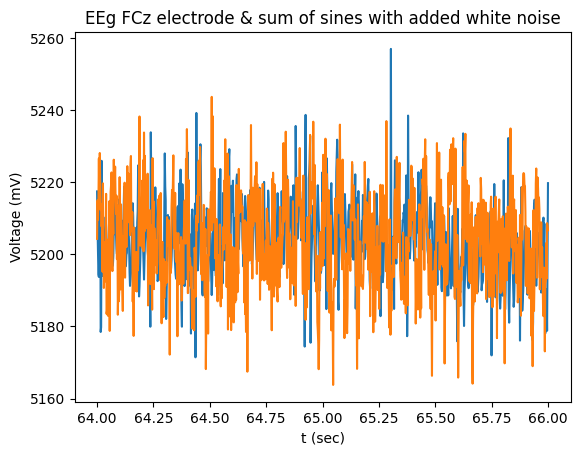

In [138]:
plt.plot(t,key_data[chosenElec][start_ind:end_ind])

sum_of_sines_with_noise = sum_of_sines + amp1*np.random.randn(np.size(sum_of_sines))
plt.plot(t,sum_of_sines_with_noise)
plt.xlabel("t (sec)")
plt.ylabel("Voltage (mV)")
plt.title("EEg FCz electrode & sum of sines with added white noise")
